# Recommendations Systems
## Homework 3:  Neural Collaborative Filtering
**By Millis Sahar** (approved by Asi)

<br>

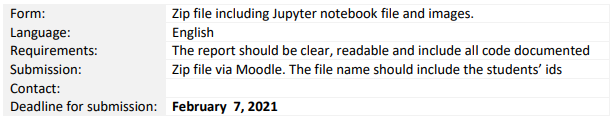

<br>

Students will form teams of two people each, and submit a single homework for each team.   
The same score for the homework will be given to each member of the team. 

Submit your solution in the form of an Jupyter notebook file (with extension ipynb).   
Images of graphs or tables should be submitted as PNG or JPG files.   
The code used to answer the questions should be included, runnable and documented in the notebook.   
Python 3.6 should be used.

The goal of this homework is to let you understand the concept of  recommendations based on implicit data which is very common in real life, and learn how ‘Deep neural networks’ components can be used to implement a collaborative filtering and hybrid approach recommenders.  
Implementation example is presented in the <a href='https://colab.research.google.com/drive/1v72_zpCObTFMbNnQXUknoQVXR1vBRX6_?usp=sharing'>NeuralCollaborativeFiltering_Implicit</a> notebook in Moodle  (and here is  <a href='https://colab.research.google.com/drive/19MHT7ewRv8TfX7eheGeLCys5mRa7neCK?usp=sharing'>Neural Collaborative Filtering Explicit</a>).

**Submission:**   
Submission of the homework will be done via Moodle by uploading a zip file containing a Jupyter notbook and images.  
The homework needs to be entirely in English.   
The deadline for submission of Homework 3 is set to February 7, 2021 end of day Israel.


We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the <a href='https://colab.research.google.com/drive/1v72_zpCObTFMbNnQXUknoQVXR1vBRX6_?usp=sharing#scrollTo=AV1al-v0zWt1'>NeuralCollaborativeFiltering_implicit</a> notebook in Moodle.

<br>
Note:
Article review: <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96</a>


<br><br><br>
<br><br><br>
<br><br><br>

# Final Results:

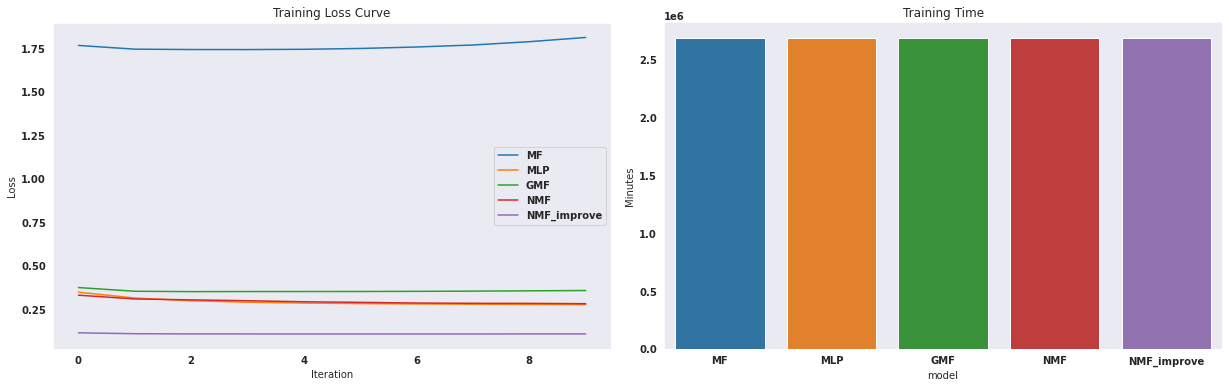
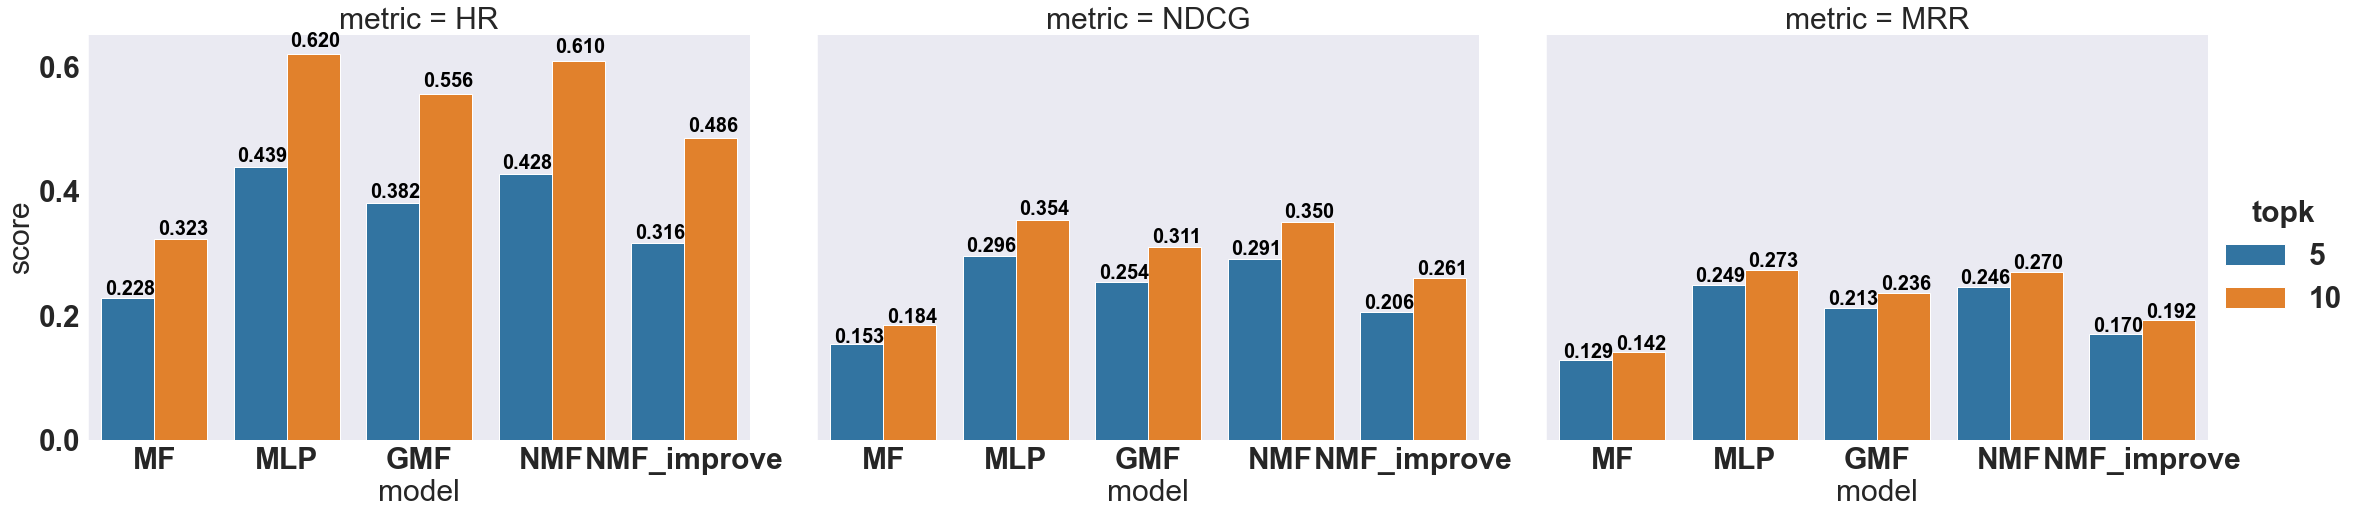


<br><br><br><br><br>
<br><br><br><br><br>

### NOTE:
    Due to computational power I trained for 10 epochs, and raised the batch to 256.
    Also, evaluate **only** when all epochs are done!
    
    I know this is not ideale! and we should eveluate after each epoch. but I had no choice!
    I timed all train & eval, and it take more then 4 hours to run it properly. and my computer can't handle that(overheats and shutdown). I tried to use Colab , but it keeps on loging me out when I pass the 2-3 hours per run.
    
    Also, if I would have evaluate the models after each epoch, I would use a line plot, instead of a bar plot. In order to see how's the epoch improve(or not) each model's metric. And I could see how it's effecting each metric simultaneously.
    
    
<br><br><br>
<br><br><br>
<br><br><br>

**Imports**

In [1]:
import os 

# colab
# from google.colab import drive  

# 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing


# general
import warnings
import numpy as np
# import scipy as sp
import pandas as pd
import scipy.sparse as sp


# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML

# logic
import tensorflow

# deep
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

**Hide Warnings**

In [2]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset preparation (10 points)
<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>

a. **Explain** the role and structure of each file and how it was created from the original MovieLens 1M rating dataset.

From the READMEFILE:     

        RATINGS FILE DESCRIPTION
        
        All ratings are contained in the file "ratings.dat" and are in the
        following format:

        UserID::MovieID::Rating::Timestamp

        - UserIDs range between 1 and 6040 
        - MovieIDs range between 1 and 3952
        - Ratings are made on a 5-star scale (whole-star ratings only)
        - Timestamp is represented in seconds since the epoch as returned by time(2)
        - Each user has at least 20 ratings

We take the original file `rating.dat` and devide it into train & test.  
- The train file `ml-1m.train.rating.txt` will include all the ratings besides the last rating of each user (sorted by the timestamp).  
- The test file `ml-1m.test.rating.txt` will inlude all just the last rating of each user.  

<br>

Finally, the file `ml-1m.test.negative.txt`, is different.  
Each line in the file contains a tubple (userId,itemId) that corresponds to the line of test.rating.  
And the rest of the row is a 99 negative samples - meaning 99 movies that the user isn't interact at all in `rating.dat`.  

<br><br><br>

b. **Explain** how the training dataset is created.

I explained it in words above, but here is an image that shows the action took on each user:
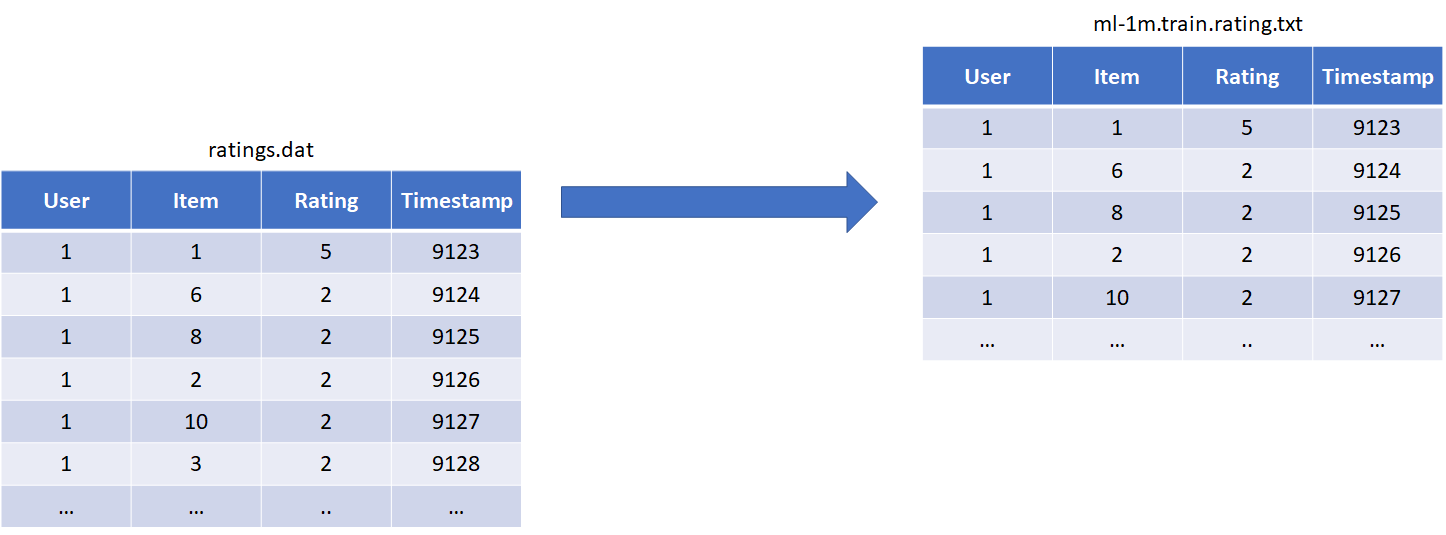

<br><br><br>

c. **Explain** how the test dataset is created.

I explained it above in word, but here is an image that shows the action took on each user:
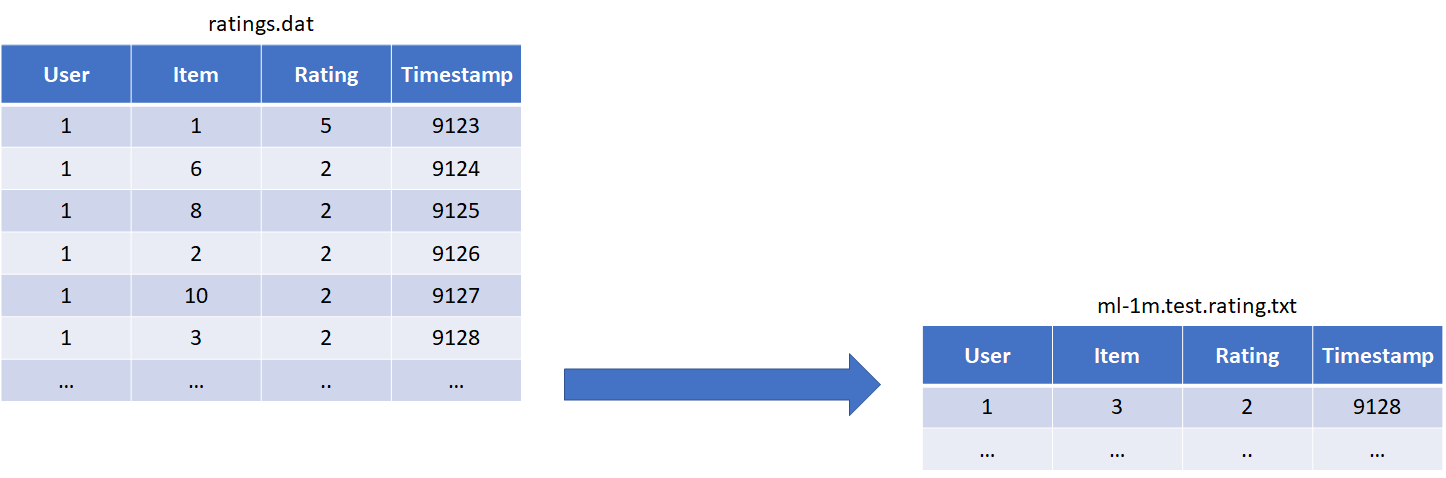

<br><br><br>

#### Data Preperations:

In [4]:
# Note: took this from the implementation Asi showed us

class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path,file_train,file_test,file_test_neg):
        '''
        Constructor
        '''
        
        self.trainMatrix = self.load_rating_file_as_matrix(path + file_train)
        self.testRatings = self.load_rating_file_as_list(path + file_test)
        self.testNegatives = self.load_negative_file(path + file_test_neg)
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.get_shape()
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat
    
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [5]:
data_dir = 'data/'
file_train    = 'ml-1m.train.rating.txt'
file_test     = 'ml-1m.test.rating.txt'
file_test_neg = 'ml-1m.test.negative.txt'

In [6]:
ratings = pd.read_csv(data_dir + file_train,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])

Users = ratings['userid'].values
Movies = ratings['movieid'].values
Ratings = ratings['rating'].values
max_userid = ratings['userid'].drop_duplicates().max() + 1
max_movieid = ratings['movieid'].drop_duplicates().max() + 1

In [7]:
dataset = Dataset(data_dir,file_train,file_test,file_test_neg)

train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.get_shape()

print("Load data done - #user=%d, #item=%d, #train=%d, #test=%d"%(num_users, num_items, train.nnz, len(testRatings)))

Load data done - #user=6040, #item=3706, #train=994169, #test=6040


<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative filtering (40 points)
<br><br>

using a costum dataset class (from sample notebook):

a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

<br><br><br><br>
**Matrix Factorization (MF)**

<br>

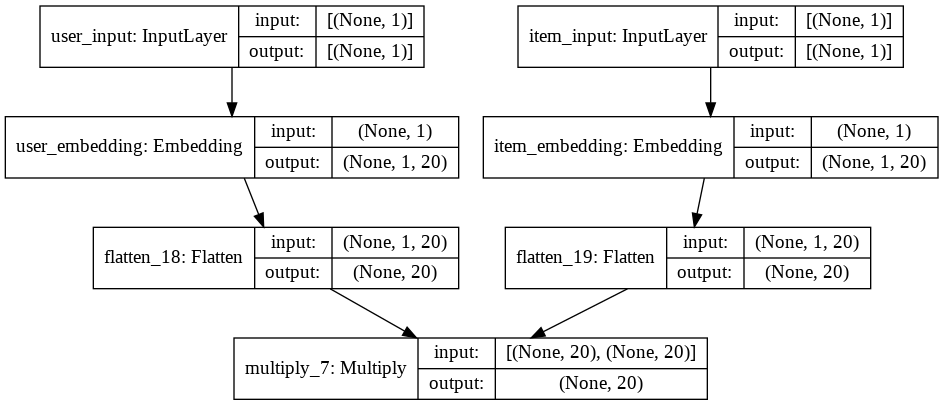

In [8]:
def get_mf_model(num_users, num_items, latent_dim):
    
    # input layer
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    # latent layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # flat
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # multiply
    prediction = Multiply()([user_latent,item_latent])
    
    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name='MF')
    return model

<br><br><br><br><br><br>
**Multi layer perceptron (MLP)**
<br>
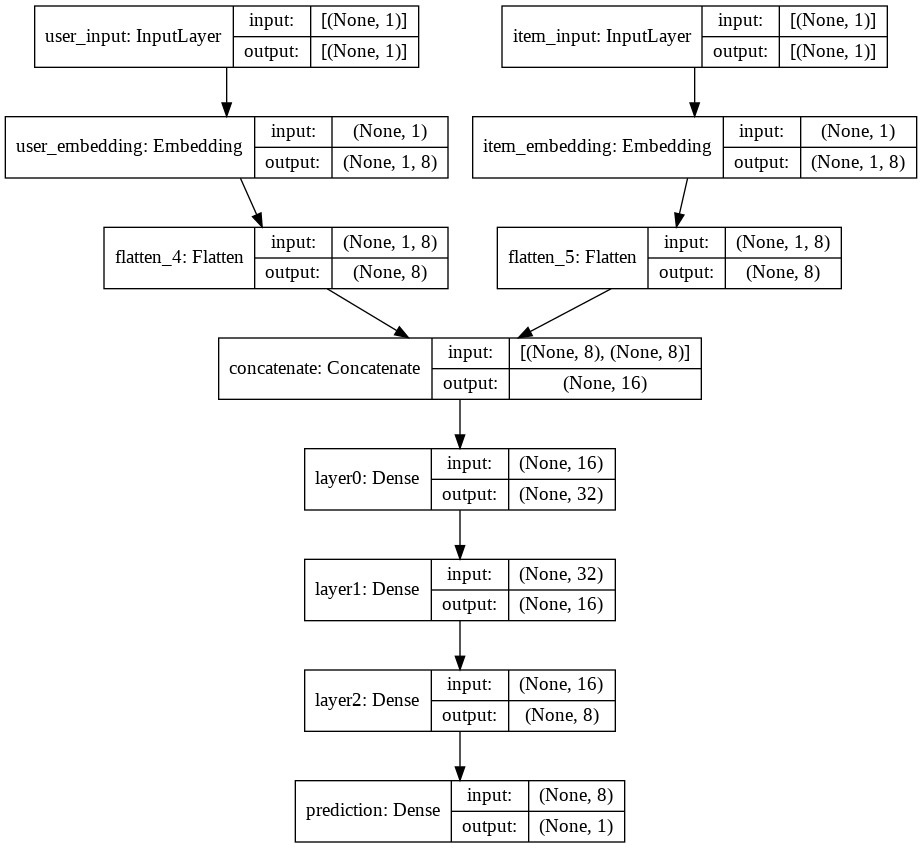

In [9]:
def get_MLP_model(num_users, num_items, latent_dim, regs=[[0,0],0,0], layers = [20,10]):
    assert len(layers) + 1 == len(regs)
    # input layer
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    # latent layer
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    # flat
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Concatenate
    vector = Concatenate(axis=-1)([user_latent, item_latent])
    
    # fully connected layers
    for idx in range(len(layers)):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)

    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name='MLP')
    return model

<br><br><br><br><br><br>
**Generalized Matrix Factorization (GMF)**
<br>
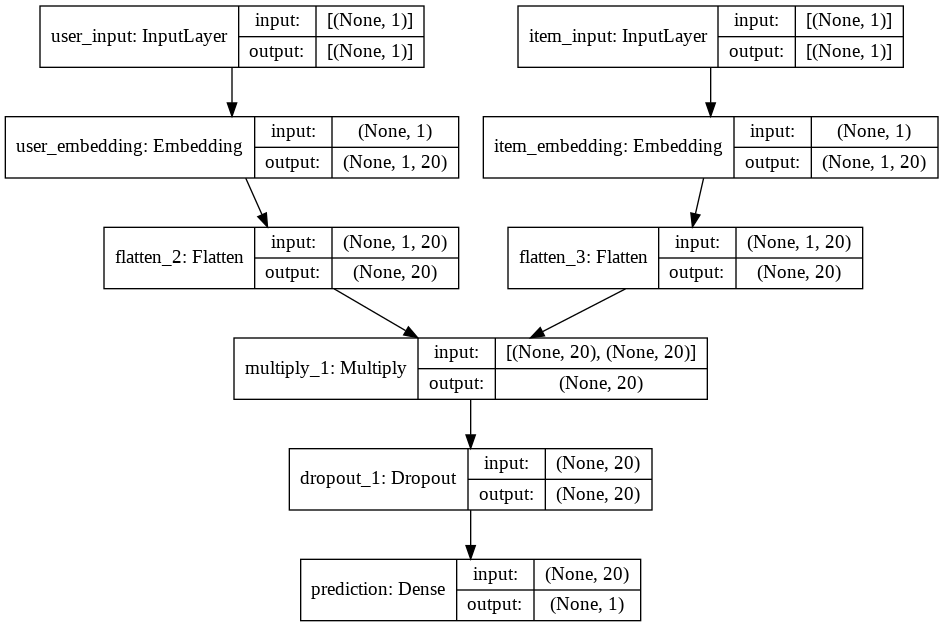

In [10]:
def get_gmf_model(num_users, num_items, latent_dim,do):

    # input layer
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    # latent layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # flat
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product
    hidden1 = Multiply()([user_latent, item_latent])
    
    # droup out layer
    drop = Dropout(do)(hidden1)
    
    # fully connected layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(drop)
    
    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name='GMF')
    return model

<br><br><br><br><br><br>
**NeuroMatrixFactorization (NMF)**

<br>

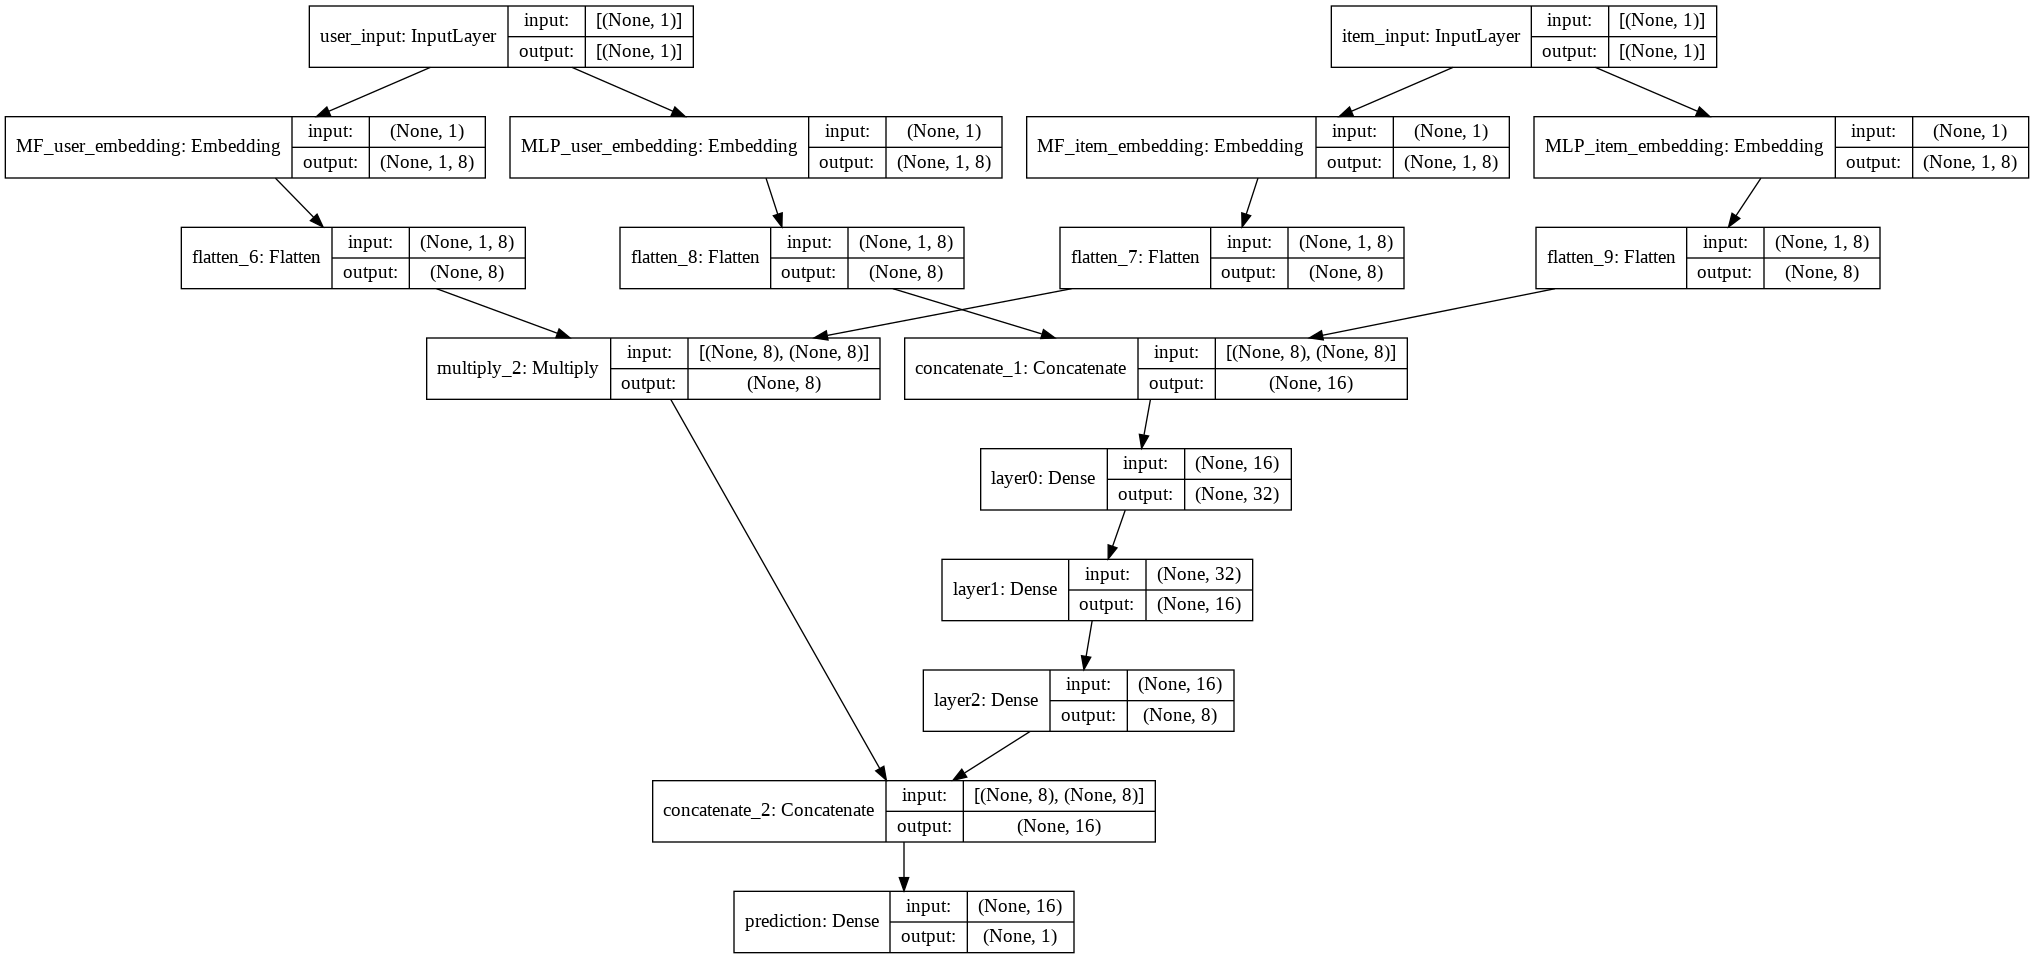

In [40]:
def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0], layers=[20,10],final_ac='sigmoid',name='NMF'):

    # input layer
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    
    # MF - latent layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # MF - flat
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # MF - Multiply
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])
    
    
    
    # MLP - latent layer
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # MLP - flat
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # MLP - Concatenate
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    
    # MLP - fully connected layers
    for idx in range(len(layers)):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

        
    # Concatenate - MF & MLP
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # fully connected layer
    prediction = Dense(1, activation=final_ac, kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    
    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name=name)
    return model

<br><br><br><br><br><br>

b. Train and evaluate the recommendations accuracy of three models: 
- MF or GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Evaluation:**

In [12]:
# Note: took this from the implementation Asi showed us


# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs = [],[],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        mrrs = [r[2] for r in res]
        return np.mean(hits), np.mean(ndcgs), np.mean(mrrs)

    # Single thread
    for idx in range(len(_testRatings)):
        (hr,ndcg,mrr) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)  
        mrrs.append(mrr)    
    return np.mean(hits), np.mean(ndcgs), np.mean(mrrs)
    

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], batch_size=batch_size, verbose=0)
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = list(predictions[i])
    items.pop()

    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr = getMRR(ranklist, gtItem)
    return (hr, ndcg, mrr)

**Metrics:**
- HitRatio
- NDCG
- MRR

In [13]:
# Note: took this from the implementation Asi showed us

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0
  
def getMRR(ranklist, gtItem):
    num_movies_tested = 0
    for item in ranklist:
        num_movies_tested += 1
        if item == gtItem:
            mrr = 1 / num_movies_tested
            return mrr
    return 0

**HyperParams:**

In [14]:
# Note: some of these values are from the implementation Asi showed us

# sampling
num_negatives = 4

# dims
num_factors = 8
K_LATENT    = 20
hidden_dim  = 20

# metrics 
top_5k = 5
top_10k = 10
evaluation_threads = 1

# training 
do = 0.5
verbose = 1
epochs   = 10
batch_size = 256
learning_rate = 1e-2

<br><br>
Create train data:

In [15]:
inputs = []
labels = []

for _ in range(epochs):
    user_input, item_input, label = get_train_instances(train, num_negatives)
    inputs.append([np.array(user_input), np.array(item_input)])
    labels.append(np.array(label))

<br><br>
save results:

In [16]:
learning_hist = {}
learning_time = {}
result_columns = ['model', 'topk','metric','score']

results = pd.DataFrame(columns = result_columns)
results

,model,topk,metric,score


<br><br>
train & eval:

In [17]:
def model_train(model):
    # initial
    learning_hist[model.name] = []
    learning_time[model.name] = time()
    
    # train
    # I could use fit_gen but my data fits into memory, so I generated all data before hand
    for i in range(epochs):
        hist = model.fit(inputs[i], labels[i], batch_size=batch_size, epochs=1, verbose=1, shuffle=True)
        learning_hist[model.name].extend(hist.history['loss'])
    
    # loss & time
    learning_time[model.name] = (time()-learning_time[model.name])/epochs/60
    add_result(model.name,0,'TIME',(time()-learning_time[model.name])/epochs/60)
    add_result(model.name,0,'LOSS',learning_hist[model.name])
    
    # eval
    add_eval(model,top_5k)
    add_eval(model,top_10k)
    

def add_eval(model,topk):
    hr,ndcg,mrr = evaluate_model(model, testRatings, testNegatives, topk, evaluation_threads)
    add_eval_result(model.name,topk,hr,ndcg,mrr)

def add_eval_result(name,topk,hr,ndcg,mrr):
    add_result(name,topk,'HR',hr)
    add_result(name,topk,'NDCG',ndcg)
    add_result(name,topk,'MRR',mrr)
    
def add_result(name,topk,metric,score):
    results.loc[len(results)] = name, topk ,metric,score

<br><br><br>
**Matrix Factorization (MF)**

In [18]:
model = get_mf_model(max_userid,max_movieid,K_LATENT)
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model)

19418/19418 [==============================] - 61s 3ms/step - loss: 1.8125


<br><br><br>
**Multi layer perceptron (MLP)**

In [19]:
model = get_MLP_model(num_users,num_items,num_factors,regs=[[0,0],0,0,0],layers=[32,16,8])
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model)

19418/19418 [==============================] - 54s 3ms/step - loss: 0.2768


<br><br><br>
**Generalized Matrix Factorization (GMF)**

In [20]:
model = get_gmf_model(max_userid,max_movieid,K_LATENT,do)
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model)

19418/19418 [==============================] - 53s 3ms/step - loss: 0.3578


<br><br><br>
**NeuroMatrixFactorization (NMF)**

In [21]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,reg_GMF=[[0,0]],regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model)

19418/19418 [==============================] - 60s 3ms/step - loss: 0.2822


<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
All Results:

In [49]:
results

,model,topk,metric,score
0,MF,0,TIME,2.68642e+06
1,MF,0,LOSS,"[1.7666953802108765, 1.7452603578567505, 1.743..."
2,MF,5,HR,0.22798
3,MF,5,NDCG,0.153461
4,MF,5,MRR,0.129026
5,MF,10,HR,0.322682
6,MF,10,NDCG,0.184213
7,MF,10,MRR,0.141787
8,MLP,0,TIME,2.68642e+06
9,MLP,0,LOSS,"[0.3481043875217438, 0.31486931443214417, 0.29..."


<br><br><br><br>
Train loss:

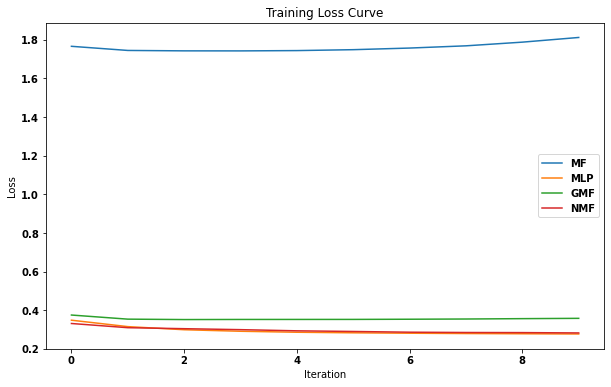

In [23]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)


plt.figure(figsize=(10,6))

for _,(name,scores) in results[results.metric=='LOSS'][['model','score']].iterrows():
    plt.plot(scores,label=name)    

plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show();


Training Time:

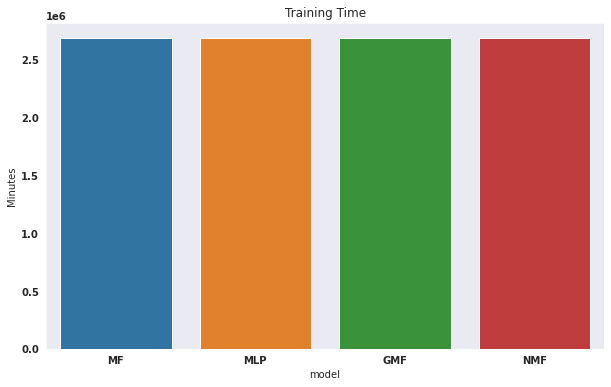

In [55]:
plt.figure(figsize=(10,6))

sns.barplot(x='model',y='score',data= results[results.metric=='TIME']);
plt.title("Training Time")
plt.ylabel('Minutes')
plt.show();

Metric Evaluation:

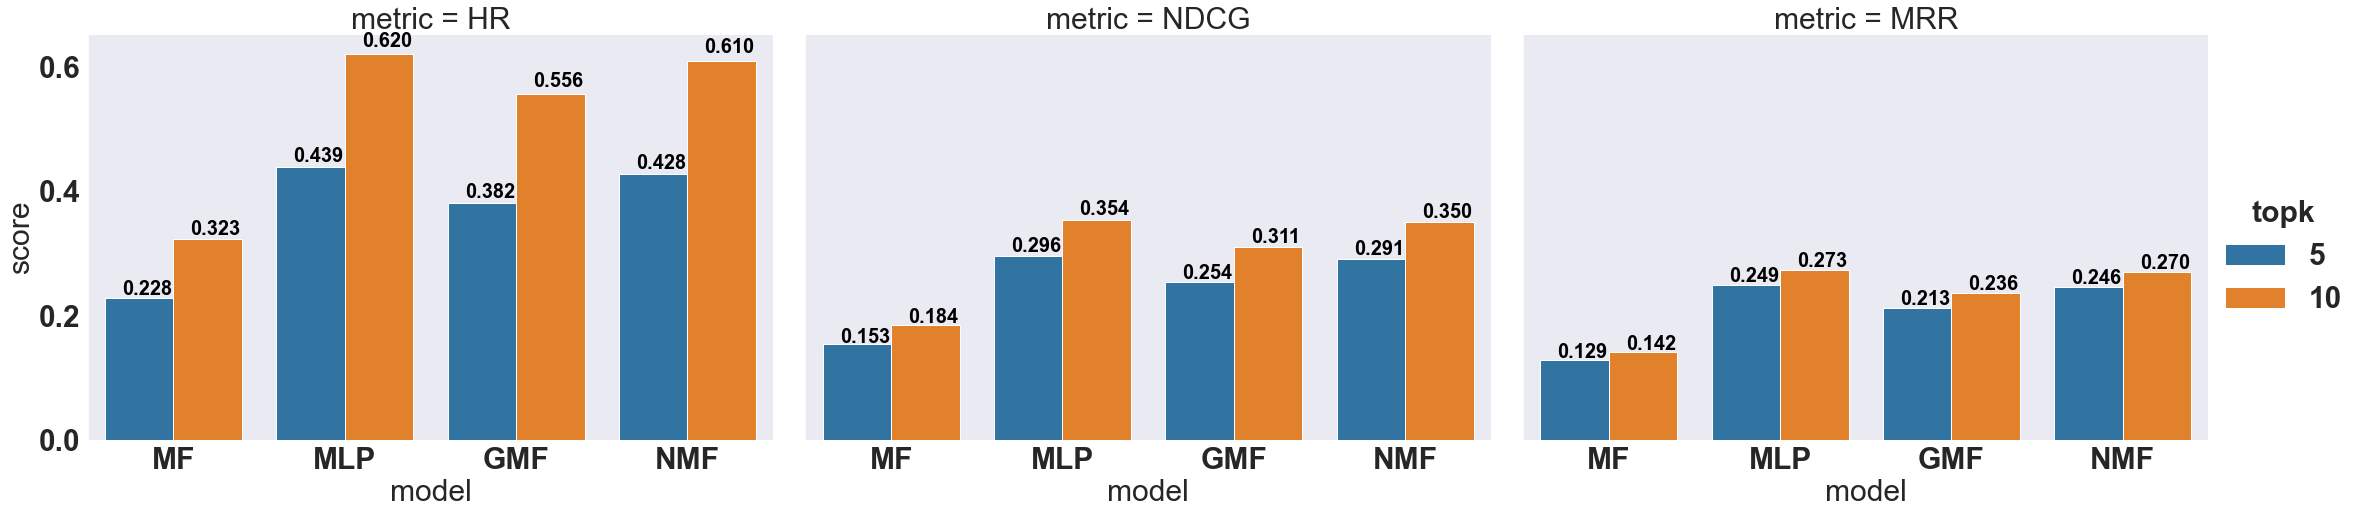

In [25]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
sns.set_style("dark")

g = sns.catplot(x="model", y="score",hue="topk",col="metric",data=results[results.topk!=0], kind="bar",col_wrap=3,height=7, aspect=1.5,ci=None);

g.fig.subplots_adjust(top=1,right=0.93) 
for i in range(3):
    ax = g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x()+0.1, 
                p.get_height() * 1.02, 
               '{0:.3f}'.format(p.get_height()), 
                color='black', 
                rotation='horizontal', 
                size='small',fontsize=20)

<br><br><br><br>
<br><br><br><br>

**c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. What are the difference in preparing the dataset for evaluation.**

I assumed the DL models will surpass the MF models.  
The current models did worse then the "simple" models in previous excircises. **Which took me by surprise**.

But! to be sure I also need to check the implicit versions of all models, cuz I still believe DL needs to do better.

Also, the eveluation here took a long time, while in previous excireces it was much quicker.  
It's due to the neg-testing which take a while to create and a long time to evaluate.
There's got to be a betterway ;)

<br><br><br>

**d. How will you measure item similarity using the NeuMF model?**

At NMF model the embedding layers are the lantent space.  
So I can use the items embeddings vector to measure similarities - Cosine,Pearson, etc.

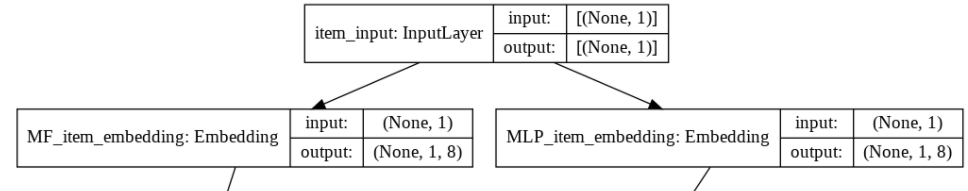

Also, in this case I used 2 different embedding layers.  
So I can use them separatly or parhaps both - dot product, mean, sum, etc.  
This I should to check, cuz I not 100% sure.


<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss function (25 points)
<br><br>

a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a Mean Squared Error and the activation function of the last layer to RELU.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

In [43]:
NAME = 'NMF_improve'
FINAL_AC = 'relu'
LOSS = 'mean_squared_error'

model = get_NMF_model(num_users,num_items,num_factors,num_factors,reg_GMF=[[0,0]],regs_MLP=[[0,0],0,0,0], layers=[32,16,8],final_ac=FINAL_AC,name=NAME)
model.compile(optimizer=Adam(lr=learning_rate), loss=LOSS)
model_train(model)

19418/19418 [==============================] - 62s 3ms/step - loss: 0.1083


<br><br><br><br>
<br><br><br><br>
NMFs Results:

In [50]:
results[results.model.str.startswith('NMF')]

,model,topk,metric,score
24,NMF,0,TIME,2.68642e+06
25,NMF,0,LOSS,"[0.3310304284095764, 0.30929091572761536, 0.30..."
26,NMF,5,HR,0.428146
27,NMF,5,NDCG,0.291025
28,NMF,5,MRR,0.245955
29,NMF,10,HR,0.61043
30,NMF,10,NDCG,0.349929
31,NMF,10,MRR,0.270241
32,NMF_improve,0,TIME,2.68643e+06
33,NMF_improve,0,LOSS,"[0.11460988968610764, 0.1094997450709343, 0.10..."


<br><br><br>
<br><br><br>

Train loss:

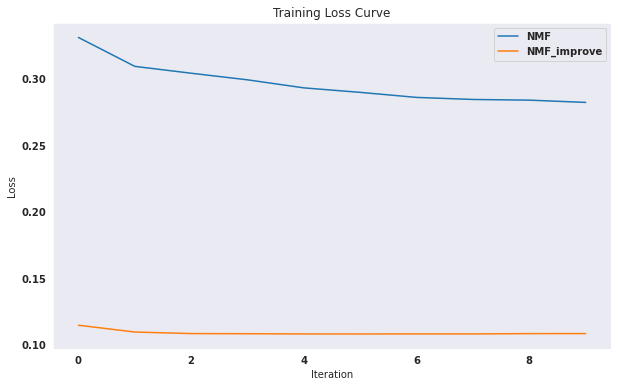

In [52]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)

plt.figure(figsize=(10,6))

for _,(name,scores) in results[results.model.str.startswith('NMF')][results.metric=='LOSS'][['model','score']].iterrows():
    plt.plot(scores,label=name)    

plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show();


<br><br><br>
Training Time:

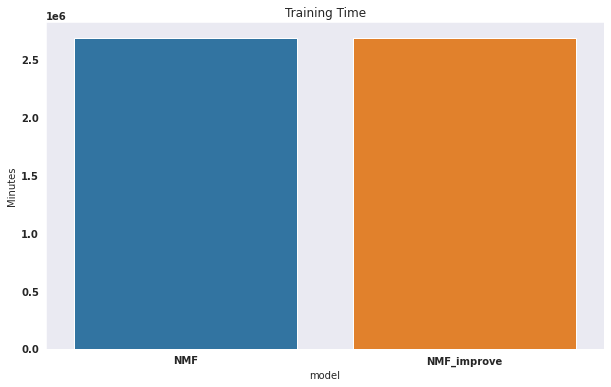

In [54]:
plt.figure(figsize=(10,6))

sns.barplot(x='model',y='score',data= results[results.model.str.startswith('NMF')][results.metric=='TIME']);
plt.title("Training Time")
plt.ylabel('Minutes')
plt.show();

<br><br><br>
Metric Evaluation:

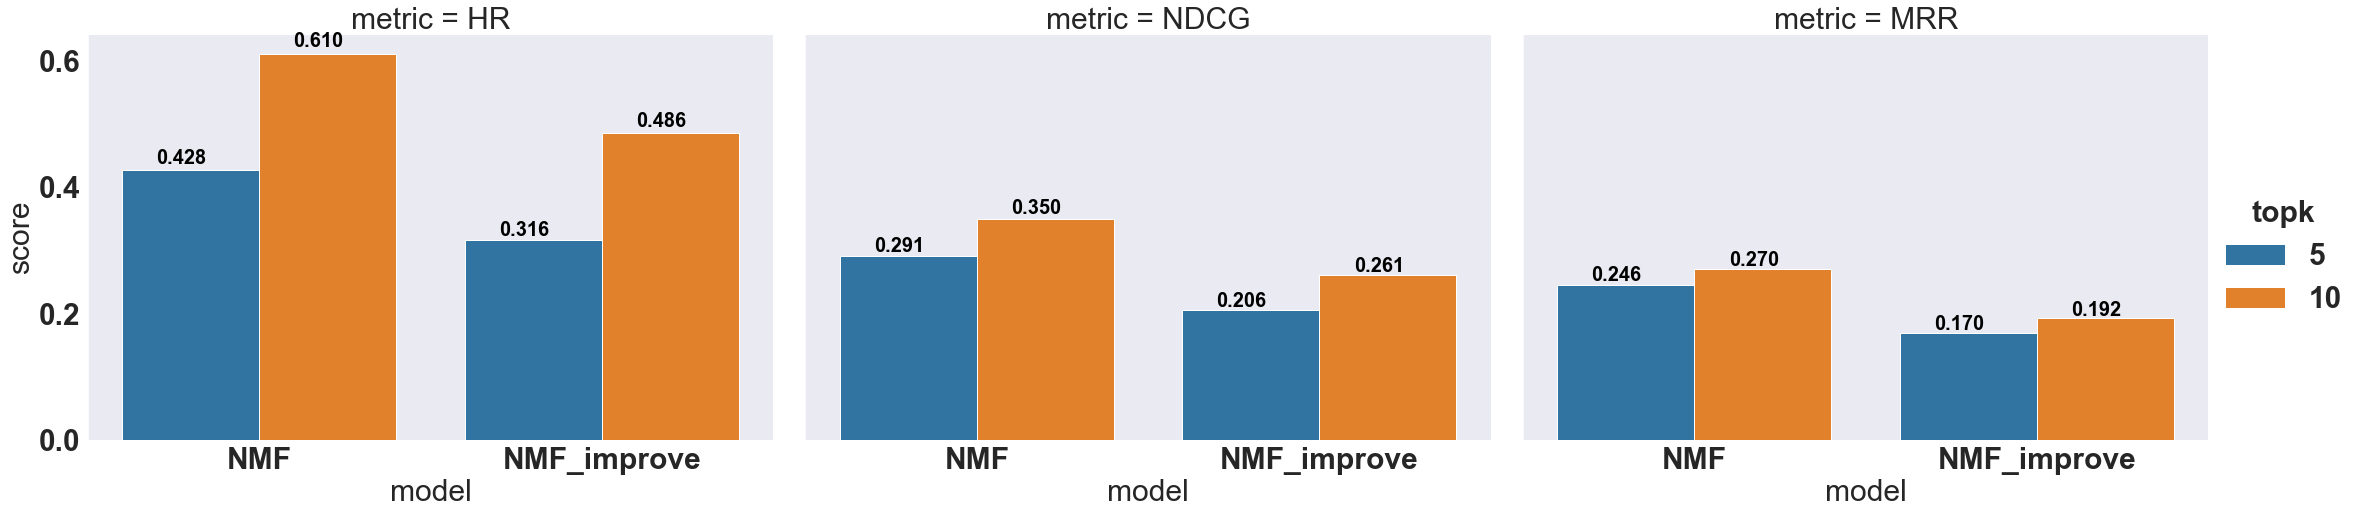

In [46]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
sns.set_style("dark")

g = sns.catplot(x="model", y="score",hue="topk",col="metric",data=results[results.model.str.startswith('NMF')][results.topk!=0], kind="bar",col_wrap=3,height=7, aspect=1.5,ci=None);

g.fig.subplots_adjust(top=1,right=0.93) 
for i in range(3):
    ax = g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x()+0.1, 
                p.get_height() * 1.02, 
               '{0:.3f}'.format(p.get_height()), 
                color='black', 
                rotation='horizontal', 
                size='small',fontsize=20)

<br><br><br><br>
**Conclusions:**

    - The improved NMF has a lower loss(1/3 then NMF), but still struggle to achieved better metrics then the NMF.   
    Althogh they are quite close. I assume that with better hyper tuning they will score about the same.  
    
    - Obviously, the low loss value is due to the different loss function.   
    And this is a great way to see that you can't use the model's loss to evaluate different models.   
    You have to rely on metrics (HR, MRR, etc.).
    
    - Both NMF & Improved NMF did not hold up to the results of "simple" models in previous excircises.
    
    - Please remember that this is on the implicit data.   
    If we would train on the explicit data, this will be different, due to the "right use" of a loss function.   
    When trying to solve a *binarry classification* - interaction or not (1 or 0) - the BCE loss is a great loss function.   
    When trying to solve a *regression problem* - user rating (1-5) - the MSE loss will be a good choice of a loss function.  
    
    - Regarding the activation function, I need to do more test to decide what will be better.
    Although I'm leaning towards Sigmoid. Due to the nature of the function. I has great performence when trying to classify.
    But! Sigmoid has a bad gradient near 0 & 1, so the models would have a problem optimizing.
    On the other hand, ReLu has the same gradient problem below 0, while above 0 will do fine.
    
    - Further work will include Hypertuning: Reg, Layers sizes, LR, n Epochs, and activation functions LeakyReLu vs Sigmoid.   
    

<br><br>
<br><br>


Thanks :)